# E-Commerce Analytics using Goggle Analytics Data

The primary aim of this project is to fulfill the role of a Product Analyst for the Google Merchandise Store:  https://shop.googlemerchandisestore.com/

It involves utilizing SQL to analyze the data from Google Analytics, which is stored in BigQuery.

We are trying to replicate [this analysis](https://www.kaggle.com/code/dillonmyrick/sql-eda-of-bigquery-google-analytics-data)

And for this purpose, we will be using the chat interface of openAI chatGPT for generating queries

### The Dataset

We are using the sessions data available in this [BQ public dataset](console.cloud.google.com/bigquery?ws=!1m5!1m4!4m3!1sbigquery-public-data!2sgoogle_analytics_sample!3sga_sessions_20170801)

Schema for the database: 

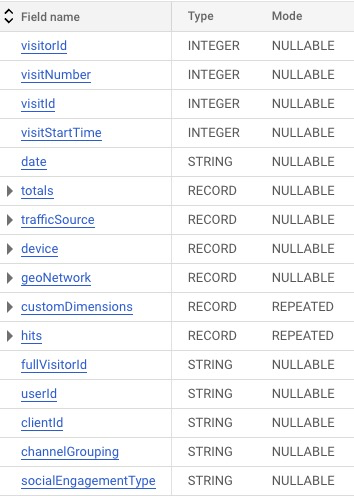

This is how you can fetch Bigquery schema in a JSON Format -

```
SELECT 
 TO_JSON_STRING(
    ARRAY_AGG(STRUCT( 
      IF(is_nullable = 'YES', 'NULLABLE', 'REQUIRED') AS mode,
      column_name AS name,
      data_type AS type)
    ORDER BY ordinal_position), TRUE) AS schema
FROM
  `bigquery-public-data.google_analytics_sample`.INFORMATION_SCHEMA.COLUMNS
WHERE
  table_name = "ga_sessions_20170127"
```

[This](https://docs.google.com/document/d/101QwERFb3t77gqXPWVm7MZCym6bQkU84l3CeoJ9BDuE/edit?mode=html) is how the json looks like!

In [ ]:
# Setting up a connection with BQ

from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account key JSON file
service_account_key_path = 'path/to/your/service_account_key.json'

# Create a BigQuery client using the service account key
credentials = service_account.Credentials.from_service_account_file(service_account_key_path)
client = bigquery.Client(credentials=credentials)

### Passing the schema to the prompt so that it can understand our data

```
> Given a bigquery google analytics table with the following schema:

`my_dataset.ga_sessions_*`

<<<INSERT SCHEMA HERE>>>

Now, I am performing an analysis, where I would need answers to certain questions. I will present the questions one by one, and I would need your help to generate queries for them. Understood?

Just give me the queries, don't explain or give any additional text. 
```

### Asking it to send the schema back to us, so that we know it has processed it correctly

```
> Before we begin, can you share the schema again? First 10 would suffice.
ChatGPT
```

## The Analysis

### 1.  Identifying most frequently visited landing pages

```
>>> Help me identify the most frequently visited landing pages and their respective bounce rates. Convert bounce rate to percentage and show only top 2 decimal places.
```

    > Query :

```sql
SELECT
  hits.page.pagePath AS landingPage,
  COUNT(*) AS visitCount,
  COUNTIF(totals.bounces = 1) AS bounceCount,
  COUNTIF(totals.bounces = 1) / COUNT(*) AS bounceRate
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  AND hits.isEntrance = TRUE
GROUP BY
  landingPage
ORDER BY
  visitCount DESC
```

### 2. Identifying which landing pages have the highest exit rates

    >>> In the same query as above, add exit rates as well. The result should be in descending order of exit rates

    > Query :

```sql
SELECT
  hits.page.pagePath AS landingPage,
  COUNT(*) AS visitCount,
  ROUND((SUM(IF(totals.bounces = 1, 1, 0)) / COUNT(*)) * 100, 2) AS bounceRate,
  ROUND((SUM(IF(hits.isExit = TRUE, 1, 0)) / COUNT(*)) * 100, 2) AS exitRate
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  AND hits.isEntrance = TRUE
GROUP BY
  landingPage
ORDER BY
  exitRate DESC
LIMIT 10
```

## 3. Checking if there are any compatibility issues between browser and device type

```
>>> I want to look at sessions by browser and device type to see if there are any compatibility issues. 

Give me the exit rates as percentages.
```

    > Query:

```sql
SELECT
  device.browser AS browser,
  device.deviceCategory AS deviceType,
  COUNT(*) AS sessionCount,
  ROUND((SUM(IF(hits.isExit = TRUE, 1, 0)) / COUNT(*)) * 100, 2) AS exitRate
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY
  browser,
  deviceType
ORDER BY
  sessionCount DESC
```

## 4. Diving deep into transaction data

```
>>> Now, I want to look at transaction data. Basically, I want exit rates, total number of transactions, total revenue and conversion rate for each traffic medium. 
```

    > Query:
    
```sql
WITH medium_stats AS (
  SELECT
    trafficSource.medium AS trafficMedium,
    COUNT(DISTINCT CONCAT(fullVisitorId, CAST(visitId AS STRING))) AS sessionCount,
    SUM(totals.transactions) AS totalTransactions,
    SUM(totals.transactionRevenue) AS totalRevenue,
    ROUND((SUM(IF(hits.isExit = TRUE, 1, 0)) / COUNT(*)) * 100, 2) AS exitRate
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND totals.transactions IS NOT NULL
  GROUP BY
    trafficMedium
)

SELECT
  trafficMedium,
  sessionCount,
  totalTransactions,
  totalRevenue / 1000000 AS totalRevenueInMillions,
  ROUND((totalTransactions / sessionCount) * 100, 2) AS conversionRate,
  exitRate
FROM
  medium_stats
ORDER BY
  sessionCount DESC
```

## 5. Understanding the conversion path for the product, basically having a brief look at the funnel

```
>>> Help me identify the conversion path for the product. 

This is what each e-commerce action type means-
1: Click through of product lists
2: Product detail views
5: Checkout
6: Completed Purchase

Tell me how many users are there at each step.

The first column should have the action, and the second column should have the number of users at that step. 
```

```
>>> In addition to the above query. Add %age dropoffs for users at each level.
```

<b>( Note : Give time to the model to think. If you provide info to it in a structured manner, it would give you better results )

    > Query 5:

```sql
WITH conversion_path AS (
  SELECT
    hits.eCommerceAction.action_type AS actionType,
    COUNT(DISTINCT fullVisitorId) AS userCount
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
    AND hits.eCommerceAction.action_type IS NOT NULL
  GROUP BY
    actionType
)

SELECT
  CASE
    WHEN actionType = '1' THEN 'Click through of product lists'
    WHEN actionType = '2' THEN 'Product detail views'
    WHEN actionType = '5' THEN 'Checkout'
    WHEN actionType = '6' THEN 'Completed Purchase'
  END AS action,
  userCount,
  ROUND(userCount / LAG(userCount) OVER (ORDER BY actionType) * 100, 2) AS dropOffPercentage
FROM
  conversion_path
ORDER BY
  actionType
```